# Cloning Content

## Introduction

The Python API team concluded we needed a guide for Cloning Content. We tackled the task to make the ultimate roadmap for how to get content from one Web GIS to another. First question to answer: What does it mean to `clone`? Merriam-Webster defines [`cloning`]() as _"propagat[ing] a clone from."_ (Didn't I hear my 2nd grade teacher - and every teacher after that for that matter - say it's unhelpful to use the word you are defining in its definition?...) So, diving into the definition of a _"clone"_ reads _"the aggregate of genetically identical cells or organisms asexually produced by or from a single progenitor cell or orgasm."_ Ok, not exactly the context we're working in when discussing a Web GIS. Further along the line we get to something more along the lines of what we're thinking: _"one that appears to be a copy of an original form."_ BINGO! 

Leveraging the Python API to clone content from one Web GIS to another can be thought of as _"propagating content that appears to be a copy of the original content."_. Given all the different content and item types, possible Enterprise configurations, potential ArcGIS Online Organization arrangements, security considerations, and item dependencies, just to name a few variables, the [`clone_items()`]((https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.clone_items)) function aims to _propagate_ an exact duplicate of one item with all its uses and functionality from an original portal to a second portal, but there may be circumstances, which can not all possibly be listed, predicted or defined here, that lead the clone to come close but not quite produce an identical copy. In addition, the variety of means for publishing items creates varying possibilities for supported, related, or source items created during the publishing process. The relationship between any supported, related, or source items must be considered when cloning an item. For example, the overwrite functionality will not be available on cloned hosted feature layer items because they do not have a source document from which they were published. The FAQ [here](https://doc.arcgis.com/en/arcgis-online/reference/faq.htm#DELETE_SRC) provides important information regarding source items in ArcGIS Online. But...given our education on `cloning`, we now know that cloning an item produces a second item which appears - but may not be identical to the original. It's important to temper expectations when thinking about the Python API `clone_items()` function. There may be times some items will not migrate as expected. 

When talking about cloning items, let's establish some basic terminology.  Cloning can refer to all kinds of transfer, from ArcGIS Enterprise to ArcGIS Online, Enterprise to Enterprise, or ArCGIS Online to Enterprise. (The GIS Community less frequently discusses the need to clone between two distinct ArcGIS Online Organizations, but that is possible as well.) Rather than tangle ourselves up when trying to distinguish between these portal types while writing about them, we'll refer to the portal or organization where the content originates as the _source_ regardless of portal type. We'll consider the portal or organization to which we'll clone content as the _target_. Onward we go!

This document illustrates the workflow of gathering _source_ items using a source administrator account, and cloning them into a _target_ administrator account.  More specifically, this guide walks through an approach of cloning data services known as [`hosted feature layers`](https://doc.arcgis.com/en/arcgis-online/manage-data/hosted-web-layers.htm) that are used as building blocks for other Web GIS items, namely [`web maps`](https://developers.arcgis.com/documentation/core-concepts/web-maps/). `Web Maps` consume these data service as. operational layer building blocks. We'll then clone an [`ArcGIS Dashboard`](https://doc.arcgis.com/en/dashboards/get-started/what-is-a-dashboard.htm) and a [`Web Mapping Application`](https://doc.arcgis.com/en/arcgis-online/create-maps/create-map-apps.htm) that each consume a `web map` as part of their definition. For information on each of these item types, please click the hyperlinks for each type.

This is an administrator workflow. Using administrator accounts guarantees all necessary privileges within the _source_ to access the item and any dependencies and within the _target_ to create the services and items. The target administrator subsequently can create user accounts and reassign item ownership and/or group membership according to need. This might also be the simplest workflow when the portal has users managed by an external identity store.

Any content in any portal must be owned by a [`user`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#user), so at least one _user_ must exist in the target. If you don't plan on using the administrator accounts in a workflow such as this, you may want to investigate the [`Clone Portal users, groups and content`](../sample-notebooks/clone-portal-users-groups-and-content/#Copy-Users) sample notebook on how to define functions that can copy `user` objects and then clone content using those accounts. 

As originally written, Python API developers designed the `clone_items()` function for transferring the following item types:
 * Hosted Web Applications built with Web AppBuilder or shared using Configurable App Templates
 * Web Maps
 * Hosted Feature Layers
 * Hosted Feature Layer Views
 * Feature Collections
 * Survey123 Forms
 * Workforce Projects
 * Story Maps
 * Operation Views
 * Dashboards
 * Feature Collections
 * Simple Types
   * Those items with a download, including file geodatabases, shapefiles, code samples, zip files, and packages amongst others

`clone_items()` clones the dependencies for the more complex items listed above. For example, cloning an existing web application, clones the web map and all hosted feature layers referenced in the map.

`clone_items()` will not clone map services and image services. Since these services can be published to servers other than the hosted server in a configuration, it's impossible for the function to determine where to publish them in the target. As a result, these items will copy over, but will continue to point back to the original source URL. 

Let's work through examples of cloning individual items, starting with hosted features services, and inspect the results.


First, let's import the necessary libraries, and connect to our source and target GIS:

### Import libraries

In [1]:
from pathlib import Path
import sys

from arcgis.gis import GIS, Item
from arcgis.env import active_gis
from arcgis.mapping import WebMap

### Connect to source and target portals

Let's start from a discovery position as an administrator. We'll simulate an administrator who's been testing and developing using an on-premise [ArcGIS Enterprise](https://enterprise.arcgis.com/en/get-started/latest/windows/what-is-arcgis-enterprise-.htm) system as a development environment who wants to clone user data into an [ArcGIS Online](https://doc.arcgis.com/en/arcgis-online/get-started/what-is-agol.htm) environment for further development.

In [2]:
source = GIS(profile="your_ent_admin_profile", verify_cert=False)
print(source)

GIS @ https://pythonapi.playground.esri.com/portal version:7.1


In [3]:
target = GIS(profile="cloning_admin", verify_cert=False)
print(target)

GIS @ https://geosaurus.maps.arcgis.com version:8.1


#### Helper Function
Let's write a set of helper functions We can reuse throughout the notebook.

Since we're working in two different portals during the notebook, we'll create a variable called `active_gis` to refer to either of these Web GIS systems.  We'll use that variable inside our functions so we can run them inside each portal.

In [85]:
active_gis = source

Next, we'll create a function that takes a `user` object and `gis` variable as input and returns a dictionary with a unique `item_type` as the key, and list of all the items of that type owned by the user as the value. Since this notebook is geared towards an `administrator` user, the administrator can retrieve the inventory of any user within the portal

In [5]:
def get_user_items(user, active_gis):
    user_inventory = {}
    user_items = active_gis.content.search(query=f"* AND owner:{user.username}", 
                                           max_items=500)
    for item in user_items:
        if not item.type in user_inventory:
            user_inventory[item.type] = [i 
                                         for i in user_items 
                                         if i.type == item.type]
    return user_inventory

Next, we'll define a function to print the output from the `get_user_items()` function we previously created and prints it in a format to give us a quick glimpse at any user's item inventory.

In [6]:
def print_user_inventory(inventory):
    for itype, ilist in inventory.items():
        try:
            print(f"{itype}\n{'-'*50}")
            for i in ilist:
                print(f"{' ':3}{i.title:50}")
            print("\n")
        except Exception as e:
            print(f"\t\tOperation failed on: {i.title}")
            print(f"\t\tException: {sys.exc_info()[1]}")
            continue

Next, we'll create a function that will take a `feature service` item type from the item inventory we create with `get_user_items()` and return any `Web Map` object within the inventory that consumes that feature service. This can help us make sure web maps contain the appropriate layers between _source_ and _target_. 

In [30]:
def get_fs_webmaps(fs, inv):
    fs_webmap_inventory = {}
    fs_inv = []
    try:
        for wm in inv['Web Map']:
            if fs.id in get_layer_item_ids(wm):
                if not wm in fs_inv:
                    fs_inv.append(wm)
        fs_webmap_inventory[fs.title] = fs_inv
        return fs_webmap_inventory
    except KeyError as ke:
        pass

We'll also create a function that inspects a `web map` and returns all the unique [`item id`](https://community.esri.com/community/gis/web-gis/arcgisonline/blog/2019/06/06/where-can-i-find-the-item-id-for-an-arcgis-online-item) (click the hyperlink to read a blog on the importance of the `item id`) values consumed in that web map. When cloning the set of `feature services` from our inventory, we'll create a mapping of _source_ feature service to corresponding _target_ feature service cloned from the _source_.  Then when we subsequently clone a `web map`, we can use the `get_layer_item_ids()` function to cmpare the item id values serving as layers in the web map to the dictionary of _source_/_target_ feature service ids we already cloned. If there are any matches between the two, we can create a dictionary to use as a parameter for the `clone_items()` function to ensure the function knows which id to match to which when swizzling the ids in the cloned map. We'll demonstrate this later in the notebook.

In [8]:
def get_layer_item_ids(wm):
    wmo = WebMap(wm)
    wm_id_list = []
    for layer in wmo.layers:
        try:
            if not layer['itemId'] in wm_id_list:
                wm_id_list.append(layer['itemId'])
        except KeyError as ke:
            pass
    return wm_id_list

We'll create a function to return a list of any `web map` items consumed in a `dashboard`. If we know the item id of the web map, and we've alreay cloned it, we can then map the _source_ web map to the _target_ web map in a parameter of the `clone_items()` function to ensure correct swizzling of values.

In [10]:
def get_dash_wm(dash):
    return [active_gis.content.get(widget['itemId']) 
            for widget in dash.get_data()['widgets'] 
            if widget['type'] == "mapWidget"]

Ok, so we've created some helper functions. Now let's inventory the items owned by the source administrator and then print out the inventory to get an idea of what items the administrator owns.

In [38]:
source_admin_inventory = get_user_items(source.users.me, source)

In [39]:
print_user_inventory(source_admin_inventory)

Map Service
--------------------------------------------------
   Jordan                                            
   Toronto Greenspace and Community Housing          


Dashboard
--------------------------------------------------
   New Orleans Service Calls                         


Web Map
--------------------------------------------------
   Elephant Corridors and Ranges                     
   Kenya Administrative Boundaries                   
   New Orleans Service Calls per Police District 2011-2019


Feature Service
--------------------------------------------------
   KEN Waterways                                     
   Airport_locations                                 
   Nairobi County Boundaries                         
   NOLA_Police_District_Subzone_Boundaries           
   New_Orleans_Boundary_gax                          
   NOLA_Police_District_Boundaries                   
   Botswana Power Plants                             
   NOLA_ServiceCallTypes_by_PoliceDis

### Suggested Cloning Order
Given the nature of dependencies in the Web GIS system and the fact the `clone_items()` function can use the `search_existing_items` parameter and the `item_mapping` parameter to ensure against repeated cloning and match up _source_ items to _target_ items, items that serve as the foundation for other items should be cloned first. In other words, work from the bottom up in terms of dependencies.  For example, a `Web Map` often contains multiple layers.  When cloning the Web Map, the software must first compile the definition of the Web Map, which cannot be completed until each Feature Layer definition within it is compiled. Then the software must clone each Feature Layer item before it clones the Web Map and wires it to the Feature Layers within the target. Instead, cloning the Feature Layer items first and then using the `item_mapping` parameter to align id values, allows the `clone_items()` function to match the _source_ item id values for a layer to the corresponding item id already existing in the target and swizzle the id value to the already exising layer and its definition instead of having to recreate the feature layer definition when creating the Web Map definition.

We can return lists of specific item_types from our inventory.  First, let's print a list of the disctinct item types avaiable for this user:

In [15]:
for item_type in list(source_admin_inventory.keys()):
    print(item_type)

Map Service
Dashboard
Feature Service
Web Map
Shapefile
File Geodatabase
Service Definition
Web Mapping Application


We can create a list of the hosted feature services using the `typeKeywords` property for items on our Feature Services:

### Feature Layers

In [16]:
hosted_fsvc = [fs 
               for fs in source_admin_inventory["Feature Service"]
               if 'Hosted Service' in fs.typeKeywords]

**Note:** This result includes `hosted feature layer views` created from hosted feature layers.  Use the `typeKeywords` `'View Service'` to isolate views.

Let's print out all the feature services for the administrator. We'll also account for any folders in the portal, and also use our previously defined `get_fs_webmaps()` function to print any web map that consumes the feature service:

In [17]:
print(f"{'Feature Layer':<33}{'Folder ID':<35}{'Folder Name':15}{'Item ID'}\n"
      f"{'-'*28:<30}{'-'*33:<35}{'-'*13:<15}{'-'*37}")
for hosted_fs in hosted_fsvc:
    fs_wm_maps = get_fs_webmaps(hosted_fs, source_admin_inventory)[hosted_fs.title]
    if not hosted_fs.ownerFolder:
        print(f"{hosted_fs.title[:30]:33}{' ':35}{'Root Folder':15}{hosted_fs.id}")
        if fs_wm_maps:
            for wm in fs_wm_maps:
                print(f"{' '*2}...consumed in {wm.title} web map")
        else:
            pass
    else:
        print(f"{hosted_fs.title[:30]:33}{hosted_fs.ownerFolder:35}"
              f"""{next(f['title'] for f in source.users.me.folders 
                   if f['id'] == hosted_fs.ownerFolder):15}"""
              f"{hosted_fs.id}")
        if fs_wm_maps:
            for wm in fs_wm_maps:
                print(f"{' '*2}...consumed in {wm.title} web map")
        else:
            pass
    print("\n")

Feature Layer                    Folder ID                          Folder Name    Item ID
----------------------------  ---------------------------------  -------------  -------------------------------------
Nairobi County Boundaries        9da120268eab46048b61364fa4c01723   Kenya          f6829ace38e14375a4b0640968a5bcec


Airport_locations                e576014b6a8a46f1a04ba2db6de51ff1   Airports       bb61578ed24c4d068a8bf521d758f6f9


Botswana Power Plants                                               Root Folder    46712cf2cc814014b314d3c77a41a7d4


New_Orleans_Boundary_gax         27d3016208e14e40887d9b3800f5a761   New Orleans    3b659cafd4dd4eb4acd09c161b307871
  ...consumed in New Orleans Service Calls per Police District 2011-2019 web map


NOLA_Police_District_Boundarie   27d3016208e14e40887d9b3800f5a761   New Orleans    7bb9efeffe8847e7bec6515ac66376a8
  ...consumed in New Orleans Service Calls per Police District 2011-2019 web map


NOLA_Police_District_Subzone_B   27d301

Now let's clone this small set of hosted feature services, alloting for any failed cloning, and replicating the _source_ folder structure as well. In addition, we'll create a python dictionary to hold the _source_ item id as the key and the cloned item id from the _target_ as the value. We'll use this dictionary later to map these feature services when cloning items that consume them.

In [18]:
hfs_map = {}
for hfs in hosted_fsvc:
    try:
        if hfs.ownerFolder:
            folder = next((f['title'] 
                          for f in source.users.me.folders 
                          if f['id'] == hfs.ownerFolder))
            if not folder in [fld['title']
                              for fld in target.users.me.folders]:
                target.content.create_folder(folder=folder)
            print(f"Cloning {hfs.title}...")
            clone_fs = target.content.clone_items([hfs], folder=folder)
            print(f"...completed")
            hfs_map[hfs.id] = clone_fs[0].id
        else:
            print(f"Cloning {hfs.title}...")
            cloned_fs = target.content.clone_items([hfs])
            print(f"...completed")
            hfs_map[hfs.id] = cloned_fs[0].id
    except Exception as e:
        print(f"...Failed to Clone {hfs.title}...")
        print(f"\tException Type: {sys.exc_info()[0]}")
        print(f"\tException Value: {sys.exc_info()[1]}")
        print(f"\tException Traceback line: {sys.exc_info()[2].tb_lineno}")
        print(f"\tException Traceback instruction: {sys.exc_info()[2].tb_lasti}")
        continue

Cloning Nairobi County Boundaries...
...completed
Cloning Airport_locations...
...completed
Cloning Botswana Power Plants...
...completed
Cloning New_Orleans_Boundary_gax...
...completed
Cloning NOLA_Police_District_Boundaries...
...completed
Cloning NOLA_Police_District_Subzone_Boundaries...
...completed
Cloning KEN_Administrative_Level_Boundaries...
...completed
Cloning NOLA_ServiceCallTypes_by_PoliceDistrict...
...completed
Cloning tlh_houshold_data_blkgrp...
...completed


Let's inspect the dictionary we created that maps the _source_ feature layer ids to the corresponding cloned feature layer ids. We can use this dictionary as the `item_mapping` argument when cloning _source_ items that consume the source feature services so the cloned item swizzles to the appropriate feature services in the _target_.

In [19]:
hfs_map

{'f6829ace38e14375a4b0640968a5bcec': 'bb55387470104cb08f4dc3d6b01142d9',
 'bb61578ed24c4d068a8bf521d758f6f9': 'ffaae71f2d264b57862f0b7a43110f10',
 '46712cf2cc814014b314d3c77a41a7d4': '77988c1dd7c34602ad42da72857864f7',
 '3b659cafd4dd4eb4acd09c161b307871': '3e9db2e70a4f4c4e82627405bd7e7c3a',
 '7bb9efeffe8847e7bec6515ac66376a8': 'da7626bc528241a8849f2f06af60aa08',
 '42874776bf8e4e7f842773d2bf5d6704': 'ee5d3fdd37394fa197ccda0c5a79929a',
 '7b4a28846f0a40efb231e800840b72ec': '3dfe9c881b4941f3968c6317d7231141',
 '7c89adbcc6e648eda313fe9ededddf44': '9d8559199bdc41e1b215e1d27eb60b94',
 'e454a494c95542168bd4fbcd13ec3641': '306f7d2a85184bc9ad1f4c3677734959'}

Let's now query the _target_ to inspect the results of cloning our feature services:

In [20]:
target_admin_inventory = get_user_items(target.users.me, target)

In [21]:
print_user_inventory(target_admin_inventory)

Feature Service
--------------------------------------------------
   NOLA_ServiceCallTypes_by_PoliceDistrict           
   NOLA_Police_District_Boundaries                   
   Botswana Power Plants                             
   NOLA_Police_District_Subzone_Boundaries           
   tlh_houshold_data_blkgrp                          
   KEN_Administrative_Level_Boundaries               
   New_Orleans_Boundary_gax                          
   Nairobi County Boundaries                         
   Airport_locations                                 




We can see that we have the same nine hosted feature services in both _source_ and _target_ Web GIS systems, and we also have a dictionary that maps the `item id` in the _source_ to the corresponding cloned `item id` in the target.

Let's examine the target feature services to see that we also recreated the folder structure:

In [22]:
target_hosted_fsvc = [fs 
               for fs in target_admin_inventory["Feature Service"]
               if 'Hosted Service' in fs.typeKeywords]

In [23]:
print(f"{'Feature Layer':<30}{'Folder ID':<35}{'Folder Name':15}{'Item ID'}\n"
      f"{'-'*28:<30}{'-'*33:<35}{'-'*13:<15}{'-'*37}")
for hosted_fs in target_hosted_fsvc:
    if not hosted_fs.ownerFolder:
        print(f"{hosted_fs.title[:28]:30}{' ':35}{'Root Folder':15}{hosted_fs.id}")
    else:
        print(f"{hosted_fs.title[:28]:30}{hosted_fs.ownerFolder:35}"
              f"""{next(f['title'] for f in target.users.me.folders 
                   if f['id'] == hosted_fs.ownerFolder):15}"""
              f"{hosted_fs.id}")

Feature Layer                 Folder ID                          Folder Name    Item ID
----------------------------  ---------------------------------  -------------  -------------------------------------
NOLA_ServiceCallTypes_by_Pol  96a3fb21430c4077aa3cd485bae59f16   New Orleans    9d8559199bdc41e1b215e1d27eb60b94
NOLA_Police_District_Boundar  96a3fb21430c4077aa3cd485bae59f16   New Orleans    da7626bc528241a8849f2f06af60aa08
Botswana Power Plants                                            Root Folder    77988c1dd7c34602ad42da72857864f7
NOLA_Police_District_Subzone  96a3fb21430c4077aa3cd485bae59f16   New Orleans    ee5d3fdd37394fa197ccda0c5a79929a
tlh_houshold_data_blkgrp      5aef1b1846cf4aed8309576ba3526726   Tallahassee    306f7d2a85184bc9ad1f4c3677734959
KEN_Administrative_Level_Bou  e6477c8695cb4095a10ad7150d8e18eb   Kenya          3dfe9c881b4941f3968c6317d7231141
New_Orleans_Boundary_gax      96a3fb21430c4077aa3cd485bae59f16   New Orleans    3e9db2e70a4f4c4e82627405bd7e7c3a
Nai

In [44]:
active_gis = target

In [31]:
print(f"{'Feature Layer':<33}{'Folder ID':<35}{'Folder Name':15}{'Item ID'}\n"
      f"{'-'*28:<30}{'-'*33:<35}{'-'*13:<15}{'-'*37}")
for hosted_fs in target_hosted_fsvc:
    try:
        fs_wm_maps = get_fs_webmaps(hosted_fs, target_admin_inventory)[hosted_fs.title]
    except TypeError as te:
        pass
        continue
    finally:
        if not hosted_fs.ownerFolder:
            print(f"{hosted_fs.title[:30]:33}{' ':35}{'Root Folder':15}{hosted_fs.id}")
            if fs_wm_maps:
                for wm in fs_wm_maps:
                    print(f"{' '*2}...consumed in {wm.title} web map")
            else:
                pass
        else:
            print(f"{hosted_fs.title[:30]:33}{hosted_fs.ownerFolder:35}"
                  f"""{next(f['title'] for f in target.users.me.folders 
                   if f['id'] == hosted_fs.ownerFolder):15}"""
                  f"{hosted_fs.id}")
            if fs_wm_maps:
                for wm in fs_wm_maps:
                    print(f"{' '*2}...consumed in {wm.title} web map")
            else:
                pass
        print("\n")

Feature Layer                    Folder ID                          Folder Name    Item ID
----------------------------  ---------------------------------  -------------  -------------------------------------
NOLA_ServiceCallTypes_by_Polic   96a3fb21430c4077aa3cd485bae59f16   New Orleans    9d8559199bdc41e1b215e1d27eb60b94


NOLA_Police_District_Boundarie   96a3fb21430c4077aa3cd485bae59f16   New Orleans    da7626bc528241a8849f2f06af60aa08


Botswana Power Plants                                               Root Folder    77988c1dd7c34602ad42da72857864f7


NOLA_Police_District_Subzone_B   96a3fb21430c4077aa3cd485bae59f16   New Orleans    ee5d3fdd37394fa197ccda0c5a79929a


tlh_houshold_data_blkgrp         5aef1b1846cf4aed8309576ba3526726   Tallahassee    306f7d2a85184bc9ad1f4c3677734959


KEN_Administrative_Level_Bound   e6477c8695cb4095a10ad7150d8e18eb   Kenya          3dfe9c881b4941f3968c6317d7231141


New_Orleans_Boundary_gax         96a3fb21430c4077aa3cd485bae59f16   New Orleans    

We can see that all the feature services now exist in the target with the same Folder structure and new `item ids`. No Web Maps consume the feature services at this point because we haven't yet cloned any.

### Web Maps

Now, let's look at the `Web Maps` in our source organization and clone them to the target. We'll revisit the source administator's `get_user_inventory` results to examine the Web Maps:

In [40]:
for wm in source_admin_inventory['Web Map']:
    wm_obj = WebMap(wm)
    print(wm_obj.item.title)

Elephant Corridors and Ranges
Kenya Administrative Boundaries
New Orleans Service Calls per Police District 2011-2019


Let's inspect what layers are in each Web Map.

We've defined a couple helper functions. One to determine wheter an item is hosted in a portal, and a second to print the layers in a webmap

In [45]:
def is_hosted(item):
    return [keyword for keyword in item.typeKeywords if "Hosted" in keyword] 

In [46]:
def print_webmap_inventory(wm):
    wm_obj = WebMap(wm)
    print(f"{wm_obj.item.title}\n{'-'*100}")
    for wm_layer in wm_obj.layers:
        try:
            if is_hosted(Item(active_gis, wm_layer['itemId'])):
                print(f"{' '*2}{wm_layer['title']:40}HOSTED{' ':5}"
                      f"{wm_layer['layerType']:20}{dict(wm_layer)['itemId']}")
            else:
                print(f"{' '*2}{wm_layer['title']:40}other{' ':6}"
                      f"{wm_layer['layerType']:20}{wm_layer.id}") 
        except:
            print(f"{' '*2}{wm_layer['title']:40}other{' ':6}"
                  f"{wm_layer['layerType']:20}{wm_layer.id}")
    print("\n")

In [48]:
# remember to set the active_gis variable when using the helper functions
active_gis = source

In [49]:
for wm in source_admin_inventory['Web Map']:
    print_webmap_inventory(wm)

Elephant Corridors and Ranges
----------------------------------------------------------------------------------------------------
  Elephant Natural Corridors              other      ArcGISFeatureLayer  Elephant_Natural_Corridors_1302
  Elephant Ranges                         other      ArcGISFeatureLayer  Elephant_Ranges_256
  KEN National Boundary                   HOSTED     ArcGISFeatureLayer  7b4a28846f0a40efb231e800840b72ec
  KEN Wetlands                            other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_7235
  KEN Waterways                           other      ArcGISFeatureLayer  Kenya_8543
  KEN Protected Areas                     other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_9906
  KEN County Boundaries                   HOSTED     ArcGISFeatureLayer  7b4a28846f0a40efb231e800840b72ec


Kenya Administrative Boundaries
----------------------------------------------------------------------------------------------------
  Ken County B

Let's use one of the helper functions we wrote earlier in the notebook to return a list of the unique `itemId` values consumed in each web map:

In [50]:
for wm in source_admin_inventory['Web Map']:
    print(f"{wm.title}\n{'-'*80}")
    for item_id in get_layer_item_ids(wm):
        print(f"{' '*2}{item_id}")
    print("\n")

Elephant Corridors and Ranges
--------------------------------------------------------------------------------
  7b4a28846f0a40efb231e800840b72ec
  357905efe88c4f509ce526db77e8d84b
  4c0a9b41665c4dd987c4ab3c70c47e73
  dbb074f0364a420bafe6c9e4215289ef


Kenya Administrative Boundaries
--------------------------------------------------------------------------------
  7b4a28846f0a40efb231e800840b72ec


New Orleans Service Calls per Police District 2011-2019
--------------------------------------------------------------------------------
  3b659cafd4dd4eb4acd09c161b307871
  7bb9efeffe8847e7bec6515ac66376a8
  7c89adbcc6e648eda313fe9ededddf44




We'll use the `hfs_map` object we created earlier, which maps _source_ feature service ids to _target_ feature service ids. In each web map, we'll query the item id values consumed in the web map, and if that item id value is a key in the `hfs_map`, we'll extract that _source_,_target_ combination and subsequently use it as the `item_mapping` argument when cloning the web map. The `item_mapping` ensures the relationship between feature services and web map remains identical between the source and target web maps.

In [52]:
wm_map = {}
for wm in source_admin_inventory['Web Map']:
    fs_item_mapping = {source:target for source,target in hfs_map.items()
                       if source in get_layer_item_ids(wm)}
    wm_obj = WebMap(wm)
    print(f"{wm_obj.item.title}\n{'-'*50}")
    if wm_obj.item.ownerFolder:
        folder_name = [f['title'] for f in source.users.me.folders 
                       if f['id'] == wm_obj.item.ownerFolder][0]
        try:
            print(f"...cloning {wm_obj.item.title}")
            cloned_wm = target.content.clone_items(items=[wm_obj.item], 
                                              folder=folder_name,
                                              item_mapping=fs_item_mapping)[0]           
            print(f"...completed")
            wm_map[wm.id] = cloned_wm.id
            print(f"\n")
        except Exception as e:
            print(f"....failed to clone {wm_obj.item.title}")
            print(str(e))
            print(f"\n")

Elephant Corridors and Ranges
--------------------------------------------------
...cloning Elephant Corridors and Ranges
...completed


Kenya Administrative Boundaries
--------------------------------------------------
...cloning Kenya Administrative Boundaries
...completed


New Orleans Service Calls per Police District 2011-2019
--------------------------------------------------
...cloning New Orleans Service Calls per Police District 2011-2019
...completed




Let's examine the resulting Web Map items in the target:

In [53]:
target_admin_inventory = get_user_items(target.users.me, target)

In [54]:
active_gis = target

In [55]:
for wm in target_admin_inventory['Web Map']:
    print_webmap_inventory(wm)

Elephant Corridors and Ranges
----------------------------------------------------------------------------------------------------
  Elephant Natural Corridors              other      ArcGISFeatureLayer  Elephant_Natural_Corridors_1302
  Elephant Ranges                         other      ArcGISFeatureLayer  Elephant_Ranges_256
  KEN National Boundary                   HOSTED     ArcGISFeatureLayer  3dfe9c881b4941f3968c6317d7231141
  KEN Wetlands                            other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_7235
  KEN Waterways                           other      ArcGISFeatureLayer  Kenya_8543
  KEN Protected Areas                     other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_9906
  KEN County Boundaries                   HOSTED     ArcGISFeatureLayer  3dfe9c881b4941f3968c6317d7231141


New Orleans Service Calls per Police District 2011-2019
-------------------------------------------------------------------------------------------

We can see that `clone_items()` successfully recreated the web maps and swizzled the layer contents to use the `item ids` of the cloned feature services. For those items that were not hosted feature layers, the function recreates them in the web map, but does not create `Feature Layer` (non-hosted) items in the Web GIS unless the `Save Layer` context menu option is used from within the target Web Map.

We also created a dictionary with the source web map id as the key and the cloned target web map id as the value to use in the `item_mapping` parameter for items that consume web maps.

In [56]:
wm_map

{'485ec5def2b14e89b95d03fcfa7537d6': '3da766d0654d422f88c5c16b13083f4b',
 '89abb46264f34953ae782748cf89e7da': '40ac460805d04c9ba984325665f96edb',
 '5dfbd0b244a440d2ac097c4bf9b381a2': 'b8a56a6cd7fd441681875304e9841cba'}

### ArcGIS Dashboards

[ArcGIS Dashboards](https://www.esri.com/en-us/arcgis/products/arcgis-dashboards/overview) use intuitive and interactive data visualizations to provide insights into your data. When you use a `Web Map` as a map element in the  dashboard the web map's operational layers can serve as data sources for other elements, providing visual and analytical insight into your data.

Let's examine the process of cloning a Dashboard by revisiting our source administrators item inventory and look into any dashboard items.

<Item title:"New Orleans Service Calls" type:Dashboard owner:arcgispyapibot>
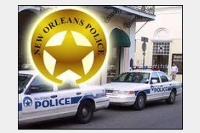

In [57]:
ops_dash = source_admin_inventory['Dashboard'][0]
ops_dash

In [58]:
active_gis = source

<Item title:"New Orleans Service Calls per Police District 2011-2019" type:Web Map owner:arcgispyapibot>
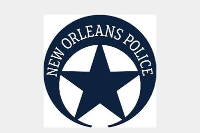

In [59]:
dash_wm = get_dash_wm(ops_dash)[0]
dash_wm

Let's visualize the web map so we can make a quick comparison to the results in our clone.

In [89]:
WebMap(dash_wm)

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

In [91]:
dash_wm.id

'5dfbd0b244a440d2ac097c4bf9b381a2'

In [60]:
print_webmap_inventory(dash_wm)

New Orleans Service Calls per Police District 2011-2019
----------------------------------------------------------------------------------------------------
  New Orleans City Boundary               HOSTED     ArcGISFeatureLayer  3b659cafd4dd4eb4acd09c161b307871
  NOLA_Police_District_Boundaries         HOSTED     ArcGISFeatureLayer  7bb9efeffe8847e7bec6515ac66376a8
  NOLA_ServiceCallTypes_by_PoliceDistrict HOSTED     ArcGISFeatureLayer  7c89adbcc6e648eda313fe9ededddf44




We used our helper functions to get a dashboard and examine the layer within the web map consumed in the dashboard.

Let's query the `wm_map` object we created to see if this `Web Map` id was cloned.

In [61]:
wm_item_mapping = {src_wm:trg_wm for src_wm,trg_wm in wm_map.items()
                  if dash_wm.id == src_wm}
wm_item_mapping

{'5dfbd0b244a440d2ac097c4bf9b381a2': 'b8a56a6cd7fd441681875304e9841cba'}

We cloned the web map used in this dashboard in our previous step of cloning web maps. We can use the `wm_item_mapping` we just created as the `item_mapping` parameter when cloning the dashboard.

In [62]:
target.content.clone_items(items=[ops_dash],
                           folder="New Orleans",
                           item_mapping=wm_item_mapping)

[<Item title:"New Orleans Service Calls" type:Dashboard owner:clonerator>]

In [63]:
target_admin_inventory = get_user_items(target.users.me, target)

<Item title:"New Orleans Service Calls" type:Dashboard owner:clonerator>
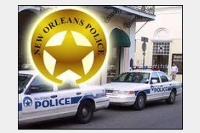

In [64]:
cloned_dash = target_admin_inventory['Dashboard'][0]
cloned_dash

In [65]:
active_gis = target

<Item title:"New Orleans Service Calls per Police District 2011-2019" type:Web Map owner:clonerator>
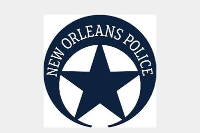

In [66]:
cloned_dash_webmap = get_dash_wm(cloned_dash)[0]
cloned_dash_webmap

In [90]:
WebMap(cloned_dash_webmap)

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

In [67]:
cloned_dash_webmap.id

'b8a56a6cd7fd441681875304e9841cba'

In [68]:
print_webmap_inventory(cloned_dash_webmap)

New Orleans Service Calls per Police District 2011-2019
----------------------------------------------------------------------------------------------------
  New Orleans City Boundary               HOSTED     ArcGISFeatureLayer  3e9db2e70a4f4c4e82627405bd7e7c3a
  NOLA_Police_District_Boundaries         HOSTED     ArcGISFeatureLayer  da7626bc528241a8849f2f06af60aa08
  NOLA_ServiceCallTypes_by_PoliceDistrict HOSTED     ArcGISFeatureLayer  9d8559199bdc41e1b215e1d27eb60b94




### Story Maps

#### ArcGIS StoryMaps
As of version 1.8, the Python API does not yet support cloning [`ArcGIS StoryMaps`](https://www.esri.com/en-us/arcgis/products/arcgis-storymaps/overview). Stay tuned for announcements as to future capability.

#### Classic Story Maps
Classic story maps are stored in the portals as `Web Mapping Application` items, so let's use them as an example of cloning a web application item.

In [69]:
active_gis = source

<Item title:"Elephant Habitat and Relationship to Water" type:Web Mapping Application owner:arcgispyapibot>
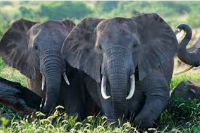

In [70]:
wma = source_admin_inventory['Web Mapping Application'][0]
wma

<Item title:"Elephant Corridors and Ranges" type:Web Map owner:arcgispyapibot>
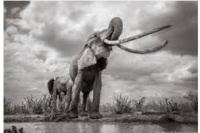

In [71]:
wma_webmap = source.content.get(wma.get_data()['values']['webmap'])
wma_webmap

For a quick visualization of the web map:

In [92]:
WebMap(wma_webmap)

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

In [84]:
wma_webmap.id

'485ec5def2b14e89b95d03fcfa7537d6'

In [73]:
print_webmap_inventory(wma_webmap)

Elephant Corridors and Ranges
----------------------------------------------------------------------------------------------------
  Elephant Natural Corridors              other      ArcGISFeatureLayer  Elephant_Natural_Corridors_1302
  Elephant Ranges                         other      ArcGISFeatureLayer  Elephant_Ranges_256
  KEN National Boundary                   HOSTED     ArcGISFeatureLayer  7b4a28846f0a40efb231e800840b72ec
  KEN Wetlands                            other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_7235
  KEN Waterways                           other      ArcGISFeatureLayer  Kenya_8543
  KEN Protected Areas                     other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_9906
  KEN County Boundaries                   HOSTED     ArcGISFeatureLayer  7b4a28846f0a40efb231e800840b72ec




Let's again query the _source_/_target_ dictionary we created when cloning the _source_ web maps to see if we've previously cloned the webmap consumed by the Story Map application.

In [75]:
wm_item_mapping = {src_wm:trg_wm for src_wm,trg_wm in wm_map.items()
                  if wma_webmap.id == src_wm}
wm_item_mapping

{'485ec5def2b14e89b95d03fcfa7537d6': '3da766d0654d422f88c5c16b13083f4b'}

The original [`Web Map`](https://developers.arcgis.com/python/api-reference/arcgis.mapping.html#webmap) contained 7 operational layers. 2 from a `hosted Feature Layer` in the `Web GIS`, and 5 `Feature Layers` items sourced from  ArcGIS Online Feature Layers. Let's use the `clone_items()` function,  accepting the default values for the `copy_data` and `search_existing_items` parameters (both `True`) and utilizing the existing item `wm_item_mapping` object to wire the application's web map. We'll then examine the results.

In [76]:
target.content.clone_items(items=[wma],
                           folder="Kenya",
                           item_mapping=wm_item_mapping)

[<Item title:"Elephant Habitat and Relationship to Water" type:Web Mapping Application owner:clonerator>]

We can see that cloning output of the `Web Mapping Application` lists the application. Let's further examine the cloned application for the items it consumes.

We'll query the target administrator inventory for the `Web Mapping Applications` now owned by the target admin, and then examine the `web map` it consumes.

In [77]:
active_gis = target

In [79]:
target_admin_inventory = get_user_items(target.users.me, target)

<Item title:"Elephant Habitat and Relationship to Water" type:Web Mapping Application owner:clonerator>
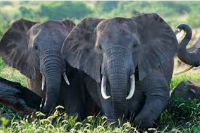

In [80]:
target_wma = target_admin_inventory['Web Mapping Application'][0]
target_wma

<Item title:"Elephant Corridors and Ranges" type:Web Map owner:clonerator>
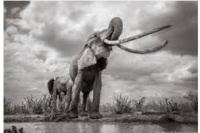

In [81]:
cloned_wma_webmap = target.content.get(target_wma.get_data()['values']['webmap'])
cloned_wma_webmap

To compare, the visualization of our cloned web map appears like our original source.

In [94]:
WebMap(cloned_wma_webmap)

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

In [82]:
cloned_wma_webmap.id

'3da766d0654d422f88c5c16b13083f4b'

In [83]:
print_webmap_inventory(cloned_wma_webmap)

Elephant Corridors and Ranges
----------------------------------------------------------------------------------------------------
  Elephant Natural Corridors              other      ArcGISFeatureLayer  Elephant_Natural_Corridors_1302
  Elephant Ranges                         other      ArcGISFeatureLayer  Elephant_Ranges_256
  KEN National Boundary                   HOSTED     ArcGISFeatureLayer  3dfe9c881b4941f3968c6317d7231141
  KEN Wetlands                            other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_7235
  KEN Waterways                           other      ArcGISFeatureLayer  Kenya_8543
  KEN Protected Areas                     other      ArcGISFeatureLayer  Kenya_Protected_Areas_and_Wetlands_9906
  KEN County Boundaries                   HOSTED     ArcGISFeatureLayer  3dfe9c881b4941f3968c6317d7231141




We can see that the `item_mapping` parameter ensured the cloned Story Map `Web Mapping Application` used the newly cloned `web map`. Examining the list of layers in the web map shos it has the same set of layers, including wiring up the layers to the correct newly cloned hosted feature services.

## Conclusion

This guide demonstrated one workflow for cloning items between a _source_ Web GIS and a _target_ Web GIS.  We connected to each GIS as an administrator, and cloned a set of items using a bottom-up approach: first cloning the data services - `feature services` that comprise other items such as `web maps`. After cloning the data building blocks, we cloned the `web maps`, and wired them to use the newly cloned feature services. We then show how the `web maps` serve as building blocks for `web mapping applications` and `dashboards`, showing how the `item_mapping` parameter can serve to ensure the cloned _target_ item consumes the correct item or data services it consumed in the _source_. 

The `clone_items()` function provides the means to deploy data services and their correpsonding items along with other more complex items that consume oither items from one Web GIS to another, maintaining the integrity of relationships between the items and its buiilding blocks.